#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Data

In [2]:
bolt_food = pd.read_csv('data/app_store_data/bolt_food_data.csv')
glovo = pd.read_csv('data/app_store_data/glovo_data.csv')
grubhub = pd.read_csv('data/app_store_data/grubhub_data.csv')
uber_eats = pd.read_csv('data/app_store_data/uber_eats_data.csv')
wolt = pd.read_csv('data/app_store_data/wolt_data.csv')

app_store = pd.concat([bolt_food, glovo, grubhub, uber_eats, wolt])

bolt_food = pd.read_csv('data/google_play_data/bolt_food_data.csv')
glovo = pd.read_csv('data/google_play_data/glovo_data.csv')
grubhub = pd.read_csv('data/google_play_data/grubhub_data.csv')
uber_eats = pd.concat([pd.read_csv(f'data/google_play_data/uber_eats_data_part{i}.csv') for i in range(1, 8)])
wolt = pd.read_csv('data/google_play_data/wolt_data.csv')

google_play = pd.concat([bolt_food, glovo, grubhub, uber_eats, wolt])

del bolt_food
del glovo
del grubhub
del uber_eats
del wolt

app_store.rename(columns={'review': 'content', 'rating': 'score', 'date': 'at'}, inplace=True)

app_store['platform'] = 'App Store'
google_play['platform'] = 'Google Play'

df = pd.concat([app_store, google_play], axis=0)
df.rename(columns={'at': 'date', 'repliedAt': 'repliedDate'}, inplace=True)

del app_store
del google_play

# EDA

In [4]:
colors = {
    'Bolt Food': '#14cf76',
    'Glovo': '#fece00',
    'Grubhub': '#ff8b00',
    'Uber Eats': '#06c168',
    'Wolt': '#009de0'
}

#### Score distribution

In [5]:
import plotly.express as px
from matplotlib import colormaps

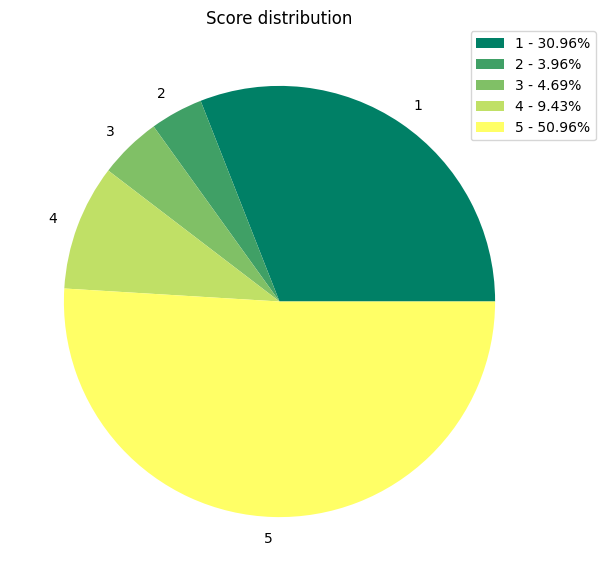

In [8]:
scoreCount = df.groupby(['score']).count().iloc[:, 0]

plt.figure(figsize=(7, 7))
plt.pie(scoreCount, labels=scoreCount.index, colors=colormaps['summer'](np.linspace(0, 1, 5)))
plt.title('Score distribution')
labels = [f"{label} - {round(percent, 2)}%" for label, percent in zip(scoreCount.index, scoreCount.to_numpy()/len(df)*100)]
plt.legend(labels, loc='right', bbox_to_anchor=(1.1, 0.9))
plt.show()

#### Share of a given application on the analyzed platforms

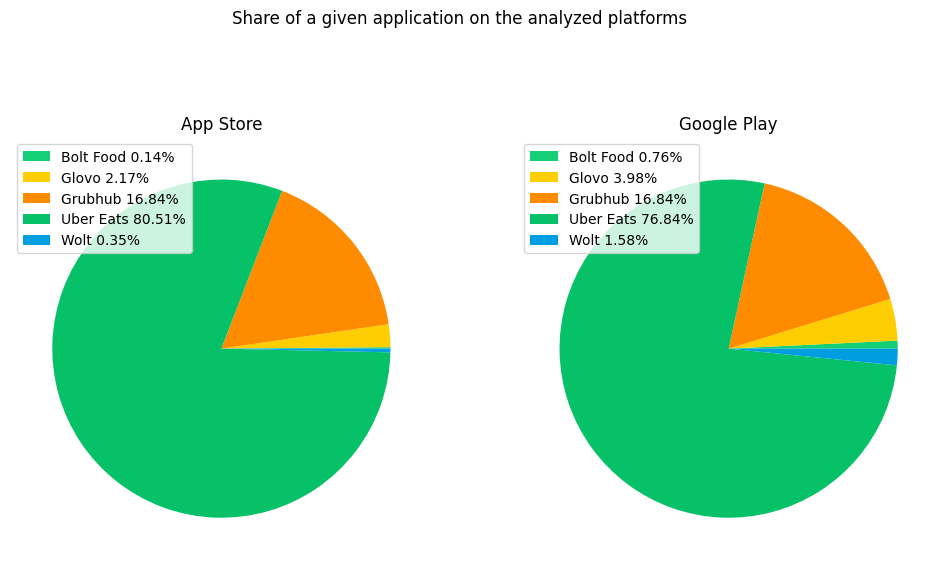

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 7))
fig.suptitle('Share of a given application on the analyzed platforms')

for i, platform in enumerate(['App Store', 'Google Play']):
    df_platform = df[df['platform'] == platform]
    appsPercentage = df_platform.groupby(['app']).count()['score']
    appsPercentage = appsPercentage.transform(lambda c: round(c/len(df_platform)*100, 2))
    ax[i].pie(appsPercentage, colors=[colors[app] for app in appsPercentage.index])
    ax[i].legend([f"{app} {percent}%" for app, percent in zip(appsPercentage.index, appsPercentage)], loc='upper left')
    ax[i].set_title(platform)

plt.show()

#### Average score of analyzed apps in recent years

In [7]:
from datetime import datetime

def confertDate(date: str):
    d, t = date.split()
    year, month, day = map(int, d.split('-'))
    hour, minut, second = map(int, t.split(':'))
    return datetime(year, month, day, hour, minut, second)

df['date'] = df['date'].transform(confertDate)

In [13]:
rating = df[['date', 'score', 'app']]
rating['year'] = rating['date'].transform(lambda d: d.year)
rating.drop(['date'], axis=1, inplace=True)
rating = rating.groupby(['app', 'year']).mean()['score']
rating = rating.to_frame().reset_index()

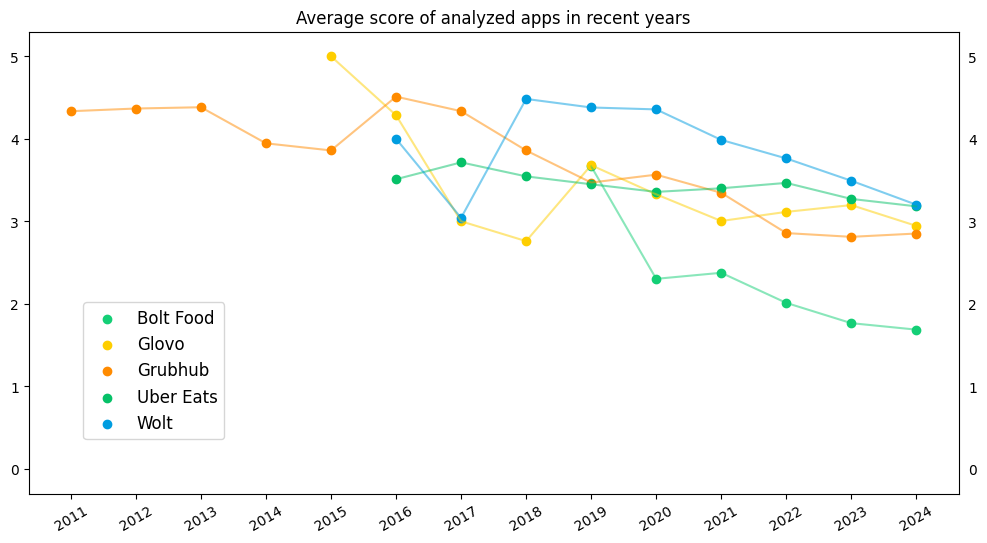

In [41]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.tick_params(labelright='on')
for app in rating.app.unique():
    rating_app = rating[rating['app'] == app]
    ax.plot(rating_app.year, rating_app.score, color=colors[app], linestyle='solid', marker='', alpha=0.5)
    ax.scatter(rating_app.year, rating_app.score, color=colors[app], label=app)

ax.set_title('Average score of analyzed apps in recent years')
ax.set_xticks(np.arange(2011, 2025))
ax.set_xticklabels(ax.get_xticks(), rotation=30)
ax.set_ylim(-0.3, 5.3)
ax.legend(loc='lower left', bbox_to_anchor=(0.05, 0.1), fontsize=12)
plt.show()

#### Rewiews distribution by date

In [42]:
# number of months between the smalles and largest date
from dateutil import relativedelta
delta = relativedelta.relativedelta(df.date.max(), df.date.min())
nMonths = delta.years * 12 + delta.months

In [43]:
# day with most reviews
df_date = df.date
df_date = pd.DataFrame(df_date)
df_date['year'] = df_date.date.transform(lambda d: d.year)
df_date['month'] = df_date.date.transform(lambda d: d.month)
df_date = df_date.groupby(['year', 'month']).count()
df_date = df_date.reset_index().sort_values('date', ascending=False)
df_date.head(1)

,year,month,date
92,2019,3,40152


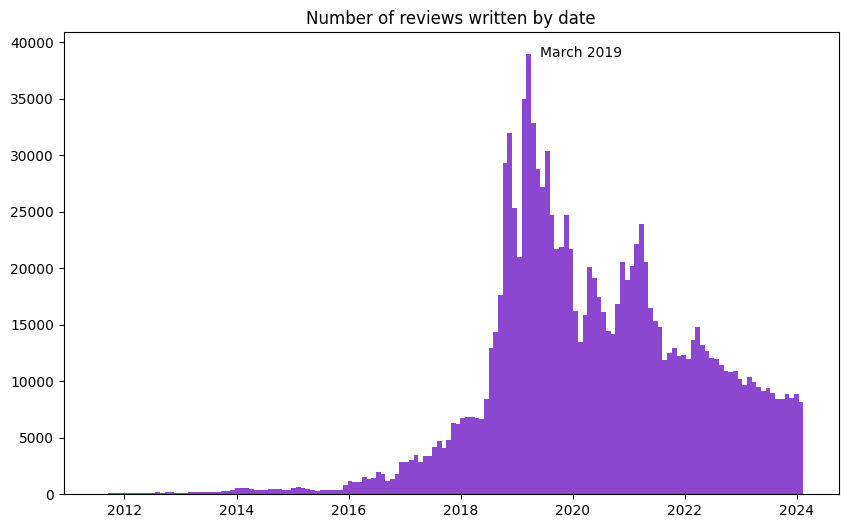

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(df.date, color='#8c47d1', bins=nMonths)
plt.text(datetime(year=2019, month=3+3, day=1), 40152-500, "March 2019", horizontalalignment='left', verticalalignment='top')
plt.title("Number of reviews written by date")
plt.show()

#### Average rating for app by platform

In [45]:
rating = df[['date', 'app', 'platform', 'score']]
rating = rating[rating.date > datetime(year=2023, month=8, day=13)] # last 6 months
rating.drop(['date'], axis=1, inplace=True)
rating = rating.groupby(['app', 'platform']).mean()['score']
rating = pd.DataFrame(rating).reset_index()

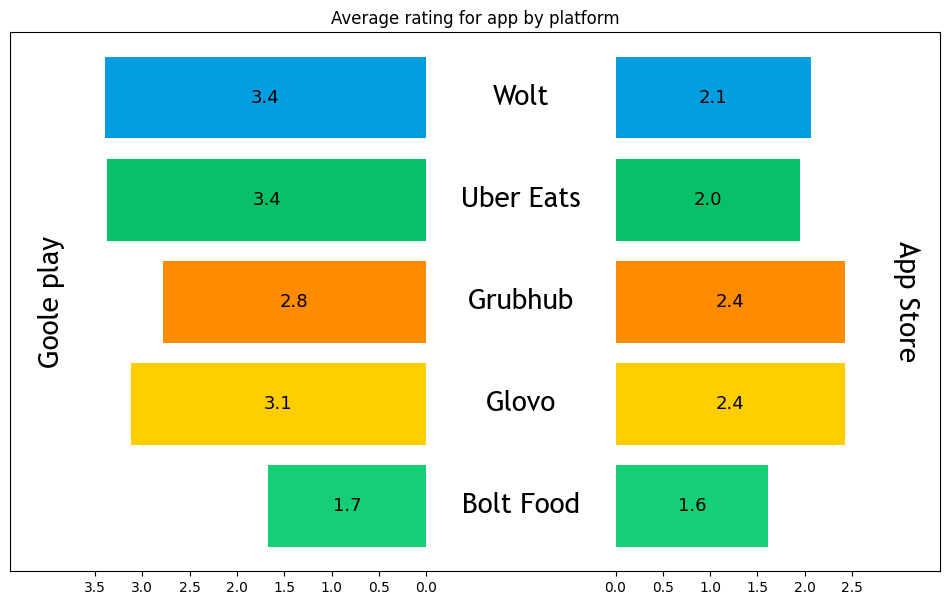

In [46]:
apps = ['Bolt Food', 'Glovo', 'Grubhub', 'Uber Eats', 'Wolt']
y = np.arange(5)
colors = ['#14cf76', '#fece00', '#ff8b00', '#06c168', '#009de0']

maxLeft = rating[rating.platform == 'Google Play']['score'].max()
maxRight = rating[rating.platform == 'App Store']['score'].max()

plt.figure(figsize=(12, 7))
for app, y, color in zip(apps, y, colors):
    appStoreWidth = rating[(rating.app == app) & (rating.platform == 'App Store')]['score']
    googlePlayWidth = rating[(rating.app == app) & (rating.platform == 'Google Play')]['score']
    plt.barh(y, appStoreWidth, color=color)
    plt.barh(y, googlePlayWidth, left=-googlePlayWidth-2, color=color)
    plt.text(appStoreWidth/2, y, str(round(float(appStoreWidth), 1)), verticalalignment='center', horizontalalignment='center', fontsize=13)
    plt.text(-googlePlayWidth/2-2, y, str(round(float(googlePlayWidth), 1)), verticalalignment='center', horizontalalignment='center', fontsize=13)
    plt.text(-1, y, app, horizontalalignment='center', verticalalignment='center', fontdict={'fontsize': 20, 'family': 'Trebuchet MS'})
plt.text(-maxLeft-2.7, 2, "Goole play", fontdict={'fontsize': 20, 'family': 'Trebuchet MS'}, rotation=90, verticalalignment='center')
plt.text(maxRight+0.5, 2, "App Store", fontdict={'fontsize': 20, 'family': 'Trebuchet MS'}, rotation=-90, verticalalignment='center')
plt.title('Average rating for app by platform')
plt.xlim(-maxLeft-3, maxRight+1)
plt.xticks(list(np.linspace(-5.5,-2,8))+list(np.linspace(0,2.5,6)), list(np.linspace(3.5,0,8))+list(np.linspace(0,2.5,6)))
plt.yticks([])
plt.show()

# Data preprocessing

In [3]:
df_pre = df[['score', 'content']]

#### Nan values

In [4]:
df_pre.isna().sum()

score        0
content    331
dtype: int64

In [5]:
df_pre.dropna(inplace=True)
df_pre.isna().sum()

score      0
content    0
dtype: int64

#### Duplicates

In [6]:
df_pre.duplicated().sum()

300963

In [7]:
df_pre.drop_duplicates(inplace=True)
df_pre.duplicated().sum()

0

#### Remove non-english comments

In [8]:
uniqueCharacters = set()
for comment in df_pre['content']:
    uniqueCharacters.update(set(list(comment)))

len(uniqueCharacters)

4035

In [9]:
# source: https://gist.github.com/bfeldman89/fb25ddb63bdaa6de6ab7ac946acde96f
emojis = pd.read_csv('data/characters/emojis.csv')
emojis = emojis.Emoji.to_list()

latinAlphabet = list(map(chr, range(65, 91)))
latinAlphabet = latinAlphabet + [char.lower() for char in latinAlphabet]

numbers = list(map(str, range(0, 10)))

specialSymbols = list("!@#$%^&*()-_=+`~[]{}\|;:'\",.<>/?")

In [10]:
other = uniqueCharacters\
    .difference(latinAlphabet)\
    .difference(emojis)\
    .difference(specialSymbols)\
    .difference(numbers)\
    .difference([" "])

other = '|'.join(other)

df_pre = df_pre[~df_pre.content.str.contains(other)]

#### Lowering Text

In [11]:
df_pre.content = df_pre.content.transform(lambda text: text.lower())

#### Removing Puncuatations

In [12]:
translate_dict = {symbol: '' for symbol in specialSymbols}
df_pre.content = df_pre.content.transform(lambda text: text.translate(translate_dict))

#### Removing Numbers

In [13]:
df_pre.content = df_pre.content.transform(lambda text: ''.join([i for i in text if not i.isdigit()]))

#### Removing Emojis

In [14]:
translate_dict = {emoji: '' for emoji in emojis}
df_pre.content = df_pre.content.transform(lambda text: text.translate(translate_dict))

#### Removing extra space

In [15]:
df_pre.content = df_pre.content.transform(lambda text: " ".join(text.split()))

#### Split to train and test data sets

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_pre['content'], df_pre['score'], test_size=0.1, random_state=42)

#### Vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
ENGLISH_STOP_WORDS = list(ENGLISH_STOP_WORDS)

vect = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, max_features=10000).fit(X_train)

X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

# Model

#### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
logReg.fit(X_train_vectorized, y_train)

LogisticRegression()

#### Prediction

In [20]:
y_pred = logReg.predict(X_test_vectorized)
y_pred

array([5, 1, 5, ..., 1, 1, 1], dtype=int64)

#### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score,

accuracy_score(y_test, y_pred)

0.751015994486299

#### Confusion Matrix

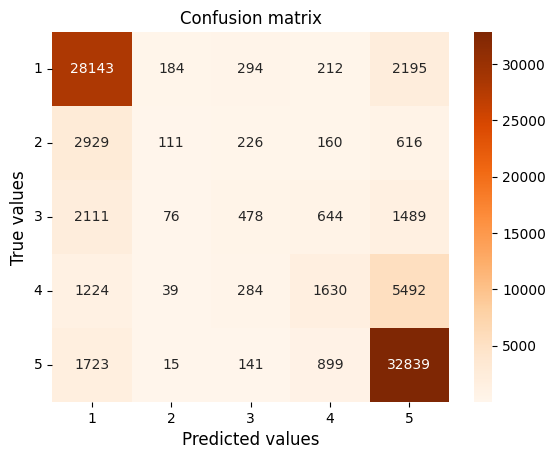

In [66]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred)

sns.heatmap(conf, annot=True, fmt='g', cmap='Oranges')
plt.title("Confusion matrix")
plt.xlabel('Predicted values', fontsize=12)
plt.ylabel('True values', fontsize=12)
plt.xticks(np.arange(5)+0.5, np.arange(1, 6))
plt.yticks(np.arange(5)+0.5, np.arange(1, 6), rotation=0)
plt.show()